In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ad_config_search.process_pylot_runs import (
    get_accuracies,
    get_coco_accuracies,
    get_latencies,
)
from tqdm import tqdm

In [2]:
def create_df_from_dir(DATA_PATH):
    unique_runs = list(set([path.stem.split(".")[0] for path in Path(DATA_PATH).iterdir()]))
    df = pd.DataFrame(columns=["model_name", "run_name", "latencies", "accuracies"])
    
    for run in tqdm(unique_runs):
        splitted_run = run.split("-")
        if splitted_run[0] == "faster":
            model_name = "frcnn"
            run_name = "-".join(splitted_run[2:])
        elif splitted_run[0] == "efficientdet":
            model_name = "edet-{}".format(splitted_run[1])
            run_name = "-".join(splitted_run[2:])
            if model_name == "edet-d6":
                continue
        elif splitted_run[0] == "ssdlite":
            model_name = "ssd-v2"
            run_name = "-".join(splitted_run[3:])
        for k,v in get_coco_accuracies(DATA_PATH, run).items():
            df = df.append({"model_name": model_name,
                            "run_name": run_name,
                            "latencies": get_latencies(DATA_PATH, run),
                            "accuracies": list(filter(lambda x: x != -1, v)),
                            "coco_metric": k}, ignore_index=True)

    df["mean_lat"] = df["latencies"].apply(lambda x: np.mean(x)/1000.)
    df["mean_mAP_acc"] = df["accuracies"].apply(lambda x: np.mean(x))
    df["town"] = df["run_name"].apply(lambda s: s.split("_")[1])
    df["train"] = df["run_name"].apply(lambda s: "train" if "Training" in s else "test")
    df["town-train"] = df["town"]+"-"+df["train"]
    df["resolution"] = df["run_name"].apply(lambda s: "({}, {})".format(*s.split("-")[-2:]))
    
    df["mAP_data_length"] = df["accuracies"].apply(lambda a: len(a))
    df["lat_data_length"] = df["latencies"].apply(lambda a: len(a))
    
    return df

In [184]:
df_timely = create_df_from_dir("../scripts/timeley_sweep_files/")

100%|██████████| 96/96 [00:11<00:00,  8.72it/s]
/home/eyal/miniconda3/envs/erdos_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning:

Mean of empty slice.



In [185]:
df_timely["timely"] = [True for _ in range(len(df_timely))]

In [186]:
df_map = create_df_from_dir("../scripts/map_sweep_files/")

100%|██████████| 96/96 [00:10<00:00,  8.94it/s]


In [187]:
df_map["timely"] = [False for _ in range(len(df_map))]

In [58]:
df_timely = df_timely.sort_values(by=["run_name"])

In [59]:
df_map = df_map.sort_values(by=["run_name"])

In [120]:
import seaborn as sns
arr = (df_map[df_map["model_name"] == "frcnn"]["mean_mAP_acc"] - df_timely[df_timely["model_name"] == "frcnn"]["mean_mAP_acc"])
arr = list(filter(lambda x: not np.isnan(x), arr))

In [121]:
np.min(arr), np.percentile(arr, 50), np.percentile(arr, 90), np.percentile(arr, 99), np.max(arr)

(-0.06692608695652169,
 0.00036109742441210274,
 0.025123085106382982,
 0.19455267500000004,
 0.4212373626373627)

In [122]:
import seaborn as sns
arr = (df_map[df_map["model_name"] == "edet-d5"]["mean_mAP_acc"] - df_timely[df_timely["model_name"] == "edet-d5"]["mean_mAP_acc"])
arr = list(filter(lambda x: not np.isnan(x), arr))

In [123]:
np.min(arr), np.percentile(arr, 50), np.percentile(arr, 90), np.percentile(arr, 99), np.max(arr)

(-0.0016964285714285716,
 0.051704731243001095,
 0.2990469382006405,
 0.6221586539880959,
 0.7254312337662338)

In [188]:
df = pd.concat([df_map, df_timely])
df = df.sort_values(by=["timely", "model_name", "coco_metric"])

In [126]:
np.mean(df_map[df_map["model_name"] == "frcnn"]["mean_lat"]), np.mean(df_map[df_map["model_name"] == "edet-d5"]["mean_lat"])

(61.26417631065661, 141.40989975709778)

In [141]:
df.columns

Index(['model_name', 'run_name', 'latencies', 'accuracies', 'coco_metric',
       'mean_lat', 'mean_mAP_acc', 'town', 'train', 'town-train', 'resolution',
       'mAP_data_length', 'lat_data_length', 'timely'],
      dtype='object')

In [182]:
df["run_name"][0].values

array(['training_0000-segment-10075870402459732738_1060_000_1080_000_with_camera_labels-1080-1920',
       'training_0000-segment-10075870402459732738_1060_000_1080_000_with_camera_labels-1080-1920'],
      dtype=object)

## Caveats
1. model colors in the 2 plots below don't match

### (270, 480) resolution

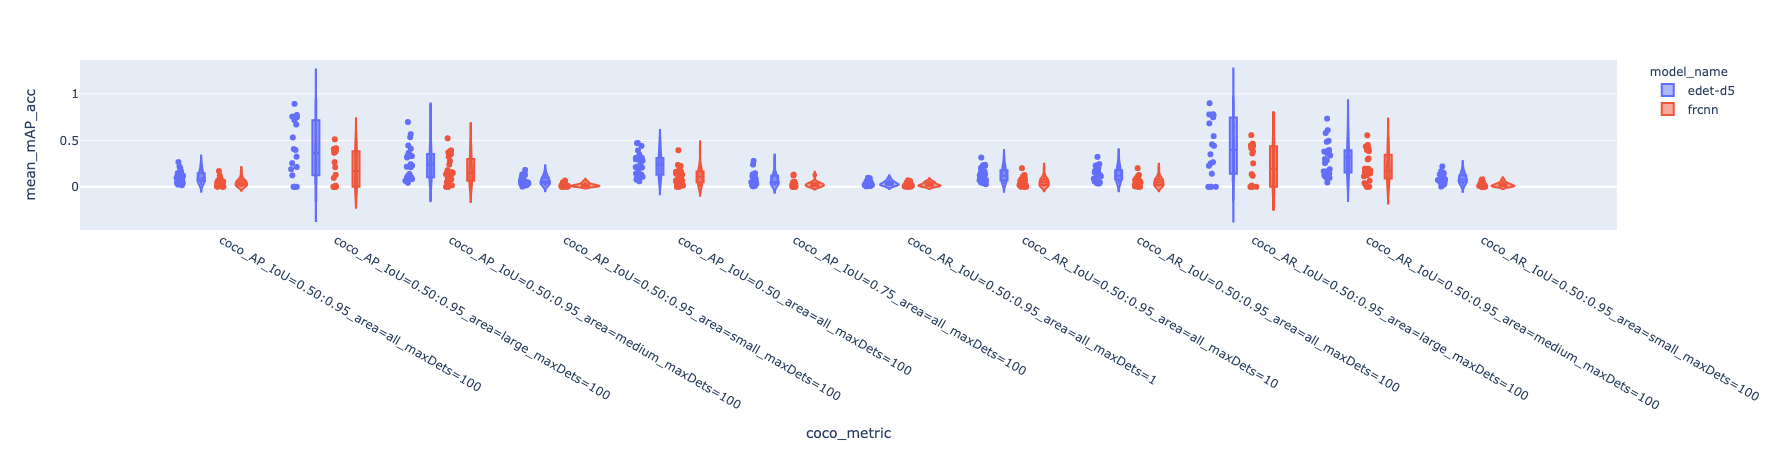

In [174]:
import plotly.express as px

fig = px.violin(df.loc[(df["resolution"] == '(270, 480)') & (df["timely"] == True)], y="mean_mAP_acc", x="coco_metric", color="model_name", box=True, points="all", hover_data=["model_name", "run_name", "mean_lat", "mean_mAP_acc"])
fig.show()

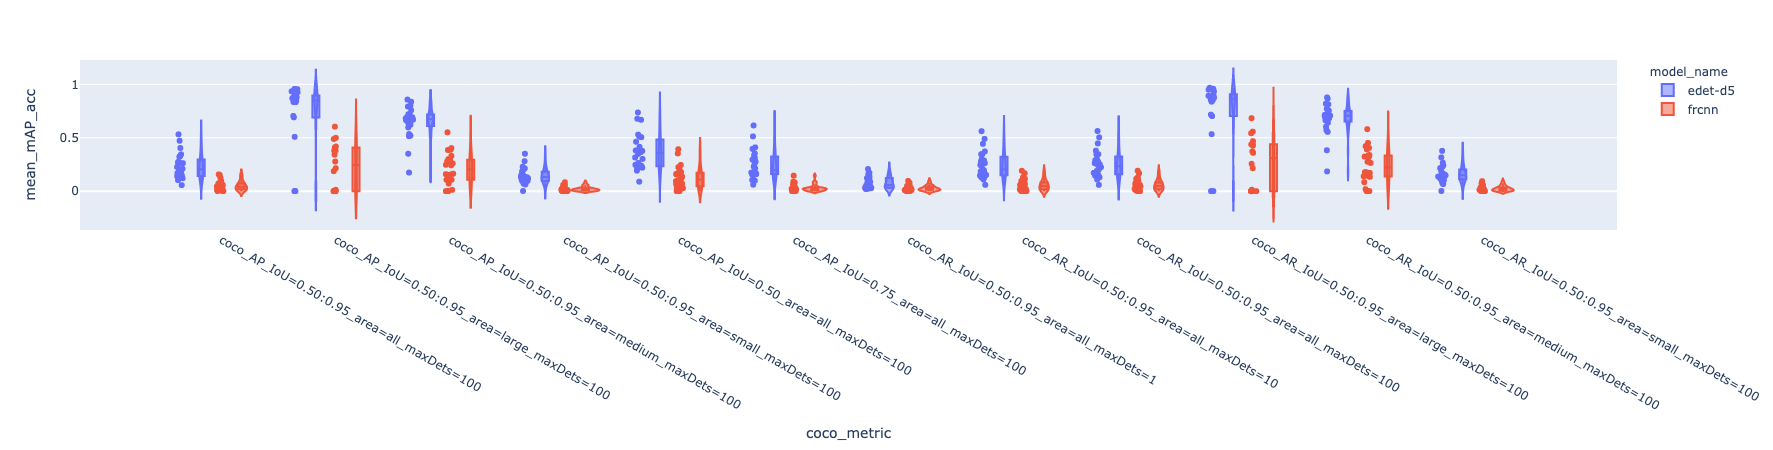

In [164]:
import plotly.express as px

fig = px.violin(df.loc[(df["resolution"] == '(270, 480)') & (df["timely"] == False)], y="mean_mAP_acc", x="coco_metric", color="model_name", box=True, points="all", hover_data=["model_name", "run_name", "mean_lat", "mean_mAP_acc"])
fig.show()

### (1080, 1920) resolution

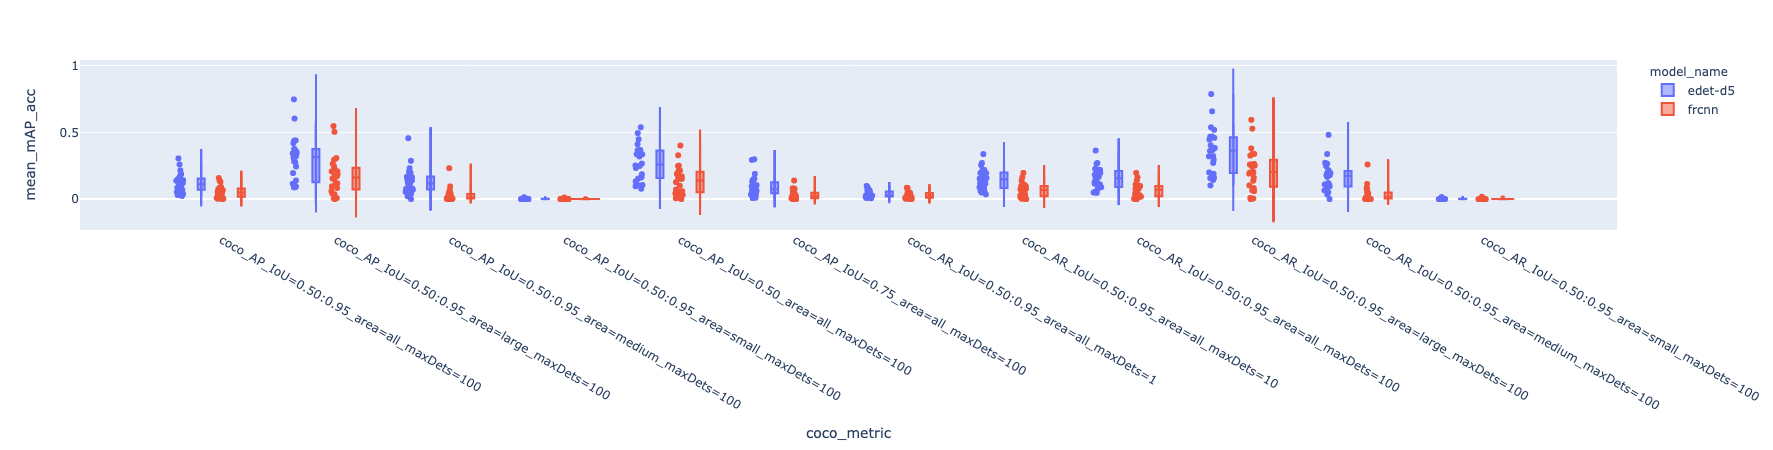

In [175]:
import plotly.express as px

fig = px.violin(df.loc[(df["resolution"] == '(1080, 1920)') & (df["timely"] == True)], y="mean_mAP_acc", x="coco_metric", color="model_name", box=True, points="all", hover_data=["model_name", "run_name", "mean_lat", "mean_mAP_acc"])
fig.show()

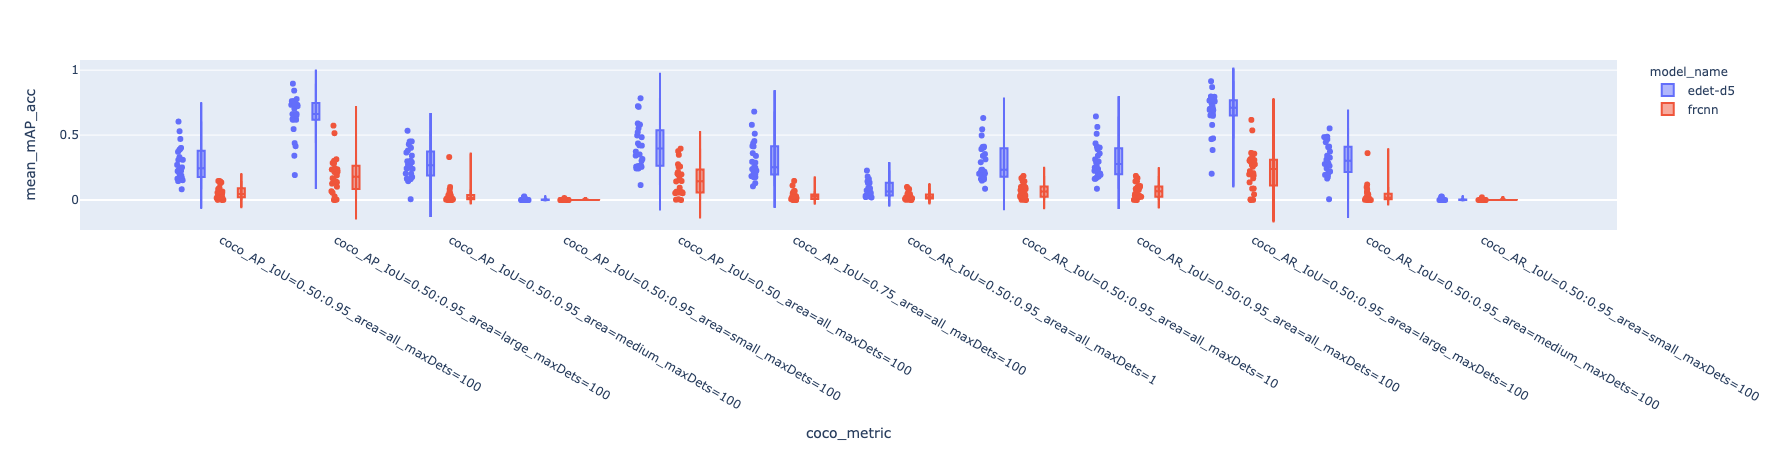

In [170]:
import plotly.express as px

fig = px.violin(df.loc[(df["resolution"] == '(1080, 1920)') & (df["timely"] == False)], y="mean_mAP_acc", x="coco_metric", color="model_name", box=True, points="all", hover_data=["model_name", "run_name", "mean_lat", "mean_mAP_acc"])
fig.show()

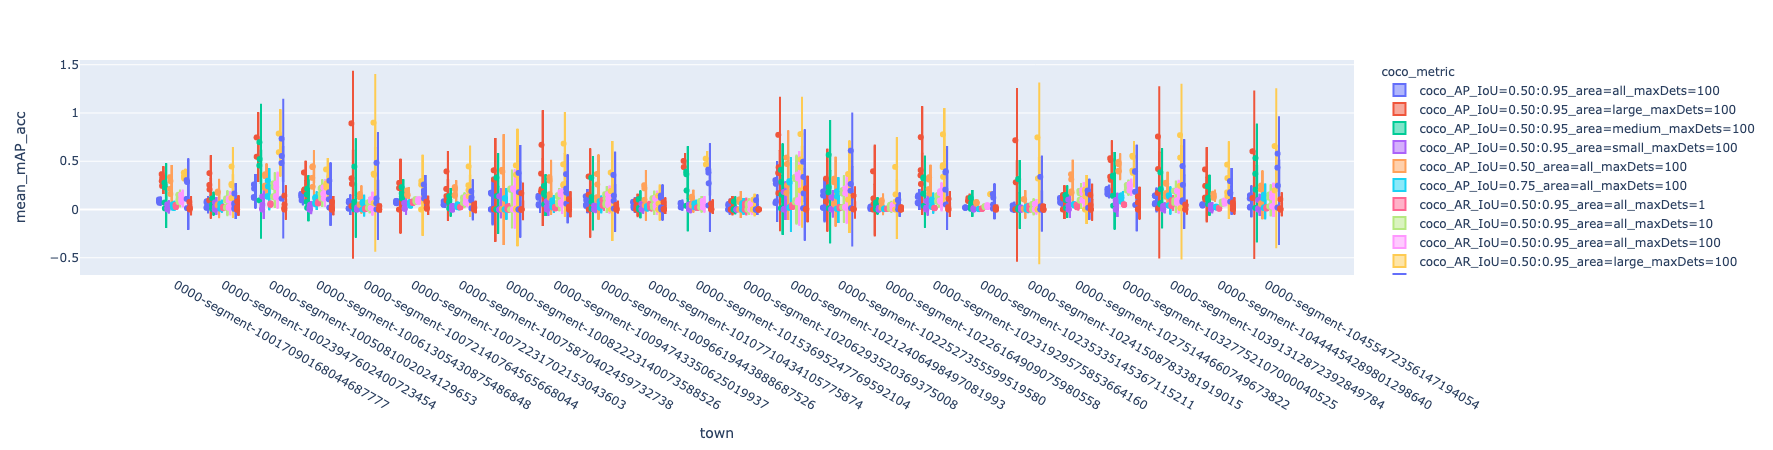

In [197]:
import plotly.express as px
df = df.sort_values(by=["town", "coco_metric"])
fig = px.violin(df.loc[df["timely"] == True], y="mean_mAP_acc", x="town", color="coco_metric", box=True, points="all", hover_data=["model_name", "resolution", "mean_lat", "mean_mAP_acc"])
fig.show()

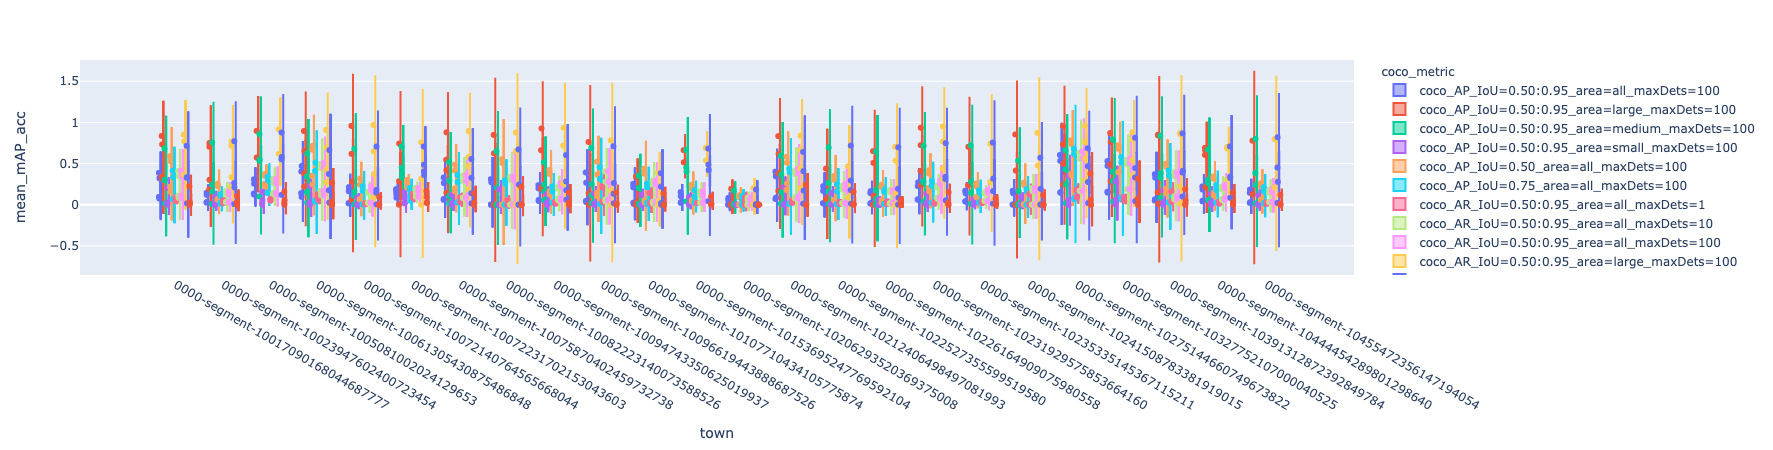

In [198]:
import plotly.express as px
df = df.sort_values(by=["town", "coco_metric"])
fig = px.violin(df.loc[df["timely"] == False], y="mean_mAP_acc", x="town", color="coco_metric", box=True, points="all", hover_data=["model_name", "resolution", "mean_lat", "mean_mAP_acc"])
fig.show()